# Ensemble

## Imports & defaults

In [1]:
import libs.analysis
import libs.helpers as helpers
import libs.plot
import libs.vars
import matplotlib
import numpy as np
import xarray

matplotlib.rcParams.update({ 'font.size': 18 })

## Data

In [2]:
ensemble = libs.vars.ensemble()

path_base = '_data/cmip6/{source_id}/{variable_id}/'
areacello_pattern = '{variable_id}_Ofx_{source_id}_piControl_{areacello_variant}_gn.nc'
var_pattern = '{variable_id}_SImon_{source_id}_ssp585_{variant_label}_gn_201501-210012_processed.nc'

area_units = 'km²'
siconc_units = '%'
variable_id = 'siconc'

# Since variables have been regridded, can use UKESM areacello
# for all ensemble member weighted means/sums
areacello_path = f'{path_base}{areacello_pattern}'.format(
    source_id='UKESM1-0-LL', 
    areacello_variant='r1i1p1f2',
    variable_id='areacello'
)
weight = xarray.open_mfdataset(
    paths=areacello_path,
    combine='by_coords',
    autoclose=True
).areacello.fillna(0)

# Get nsidc region mask, which has been regridded to UKESM ocean grid
path_nsidc_mask = '_data/_cache/NSIDC_Regions_Masks_Ocean_nearest_s2d.nc'
nsidc_mask = xarray.open_mfdataset(paths=path_nsidc_mask, combine='by_coords').mask

for i, item in enumerate(ensemble):
    source_id = item['source_id']
    variant_label = item['variant_label']

    var_path = f'{path_base}{var_pattern}'.format(
        source_id=source_id, 
        variant_label=variant_label,
        variable_id=variable_id
    )
    
    data = xarray.open_mfdataset(
        paths=var_path,
        combine='by_coords',
        autoclose=True,
        use_cftime=True
    )
    
    # Mask data to arctic + nsidc regions
    data[variable_id] = data[variable_id]\
        .where(data[variable_id].latitude > 60)\
        .where(nsidc_mask.values > 0)
    
    ensemble[i]['data'] = data[variable_id]
    ensemble[i]['label'] = data.attrs['source_id']


si_arr_weighted_sum = []
si_arr_weighted_sum_smooth = []
for item in ensemble:
    si_weighted = (item['data'] / (1000 * 1000)).weighted(weight)
    si_weighted_sum = si_weighted.sum(dim=si_weighted.weights.dims, skipna=True)

    si_arr_weighted_sum.append({
        'data': si_weighted_sum,
        'label': item['label']
    })
    si_arr_weighted_sum_smooth.append({
        'data': libs.analysis.smoothed_mean(si_weighted_sum),
        'label': item['label']
    })

si_arr_weighted_sum_smooth.append(
    libs.analysis.ensemble_mean(si_arr_weighted_sum_smooth)
)

# Generate slices
ensemble_time_slices = libs.analysis.generate_slices(ensemble)

## Time series

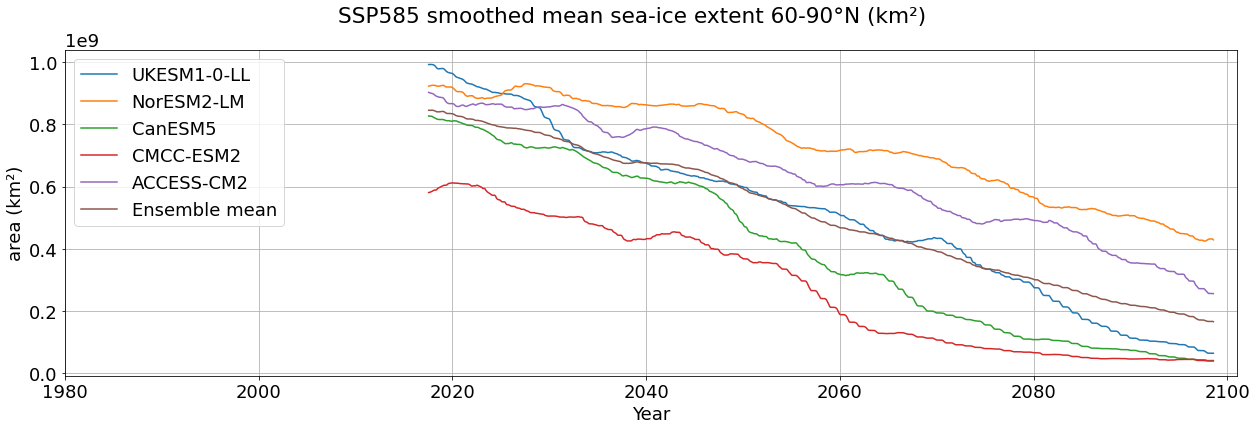

In [3]:
libs.plot.time_series(
    si_arr_weighted_sum_smooth,
    title=f'SSP585 smoothed mean sea-ice extent 60-90°N ({area_units})',
    xattr='time',
    ylabel=f'area ({area_units})'
)

### Full variability

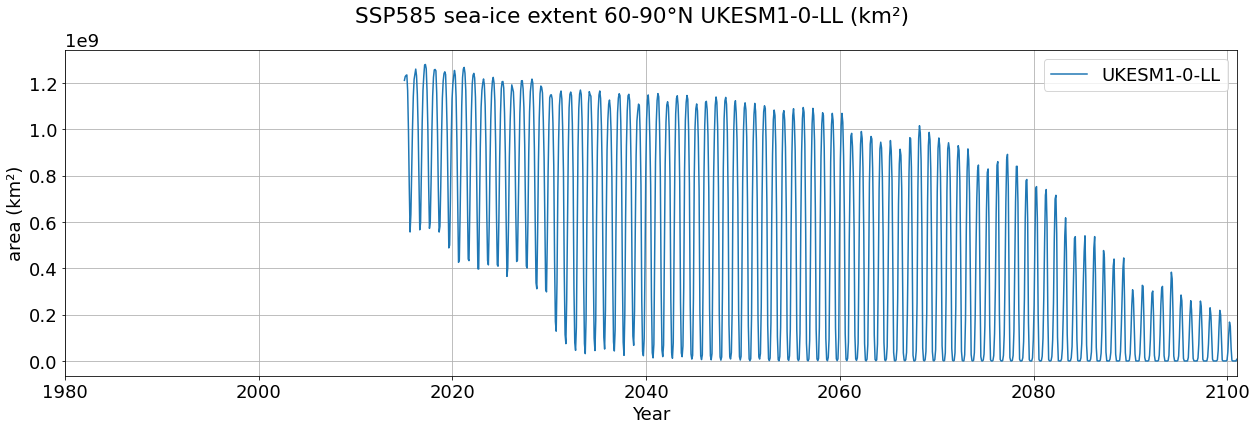

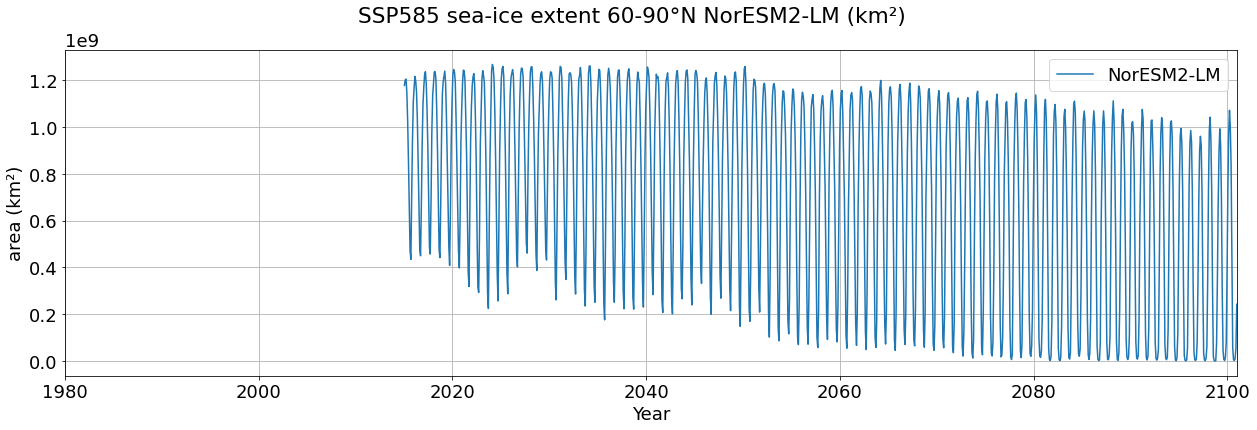

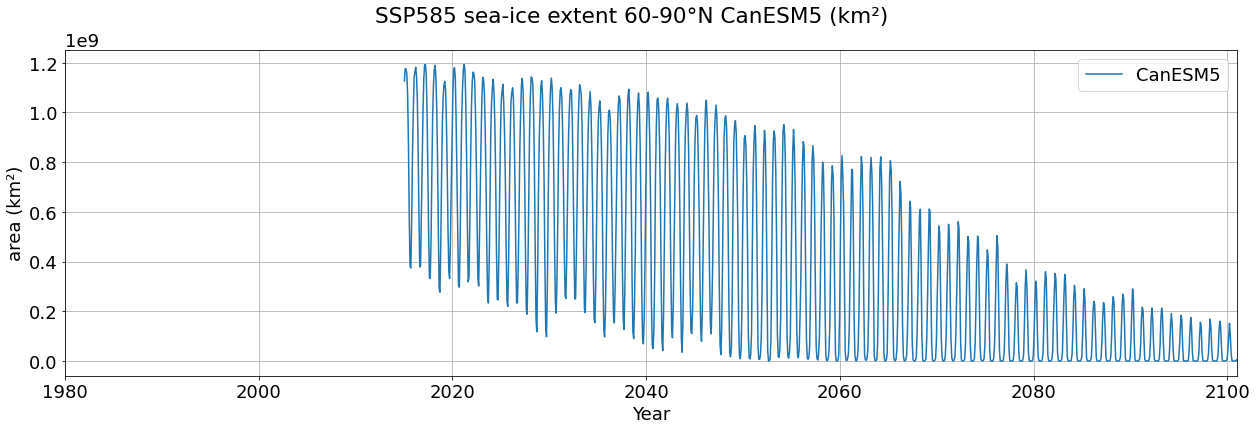

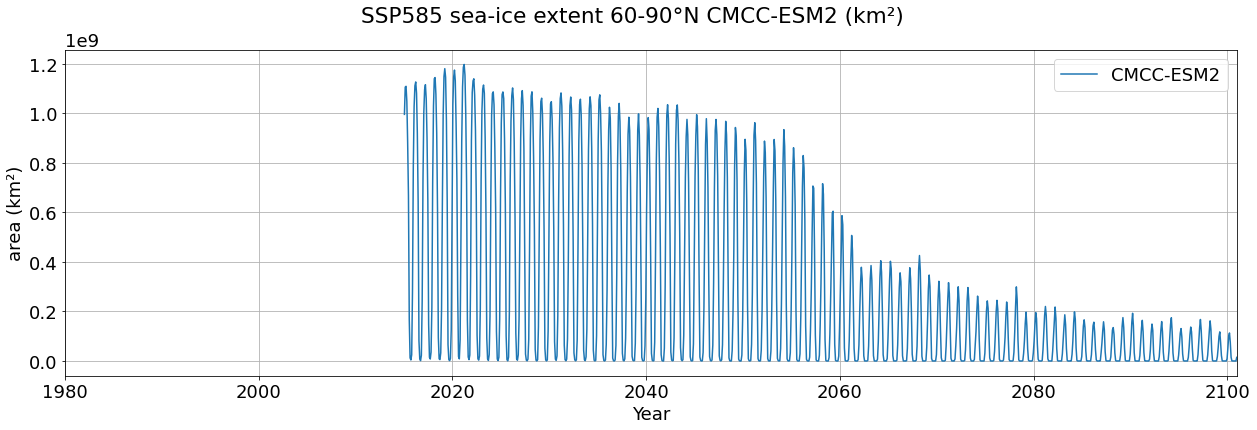

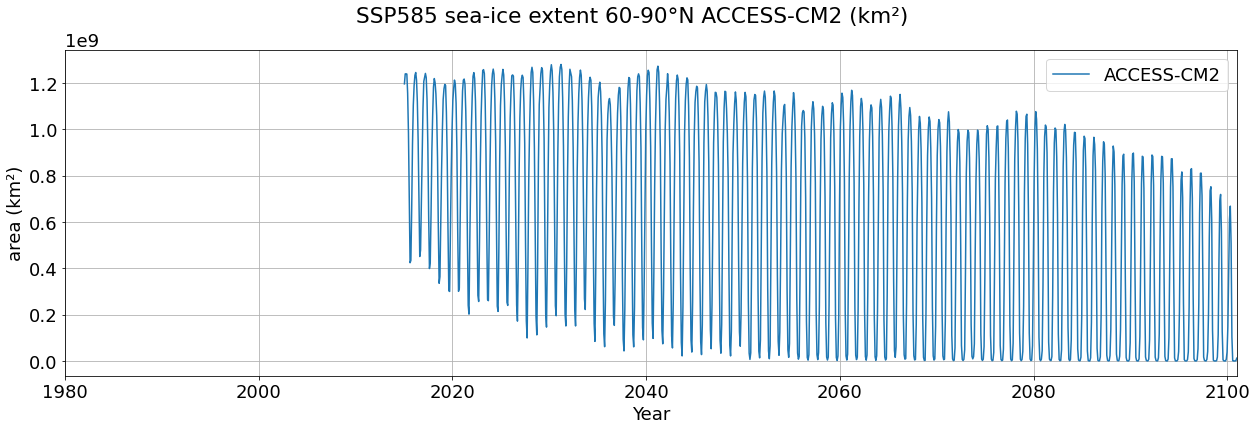

In [4]:
for item in si_arr_weighted_sum:
    member = item['label']

    libs.plot.time_series(
        [item],
        title=f'SSP585 sea-ice extent 60-90°N {member} ({area_units})',
        xattr='time',
        ylabel=f'area ({area_units})'
    )

## Monthly variability

### Full region (time)

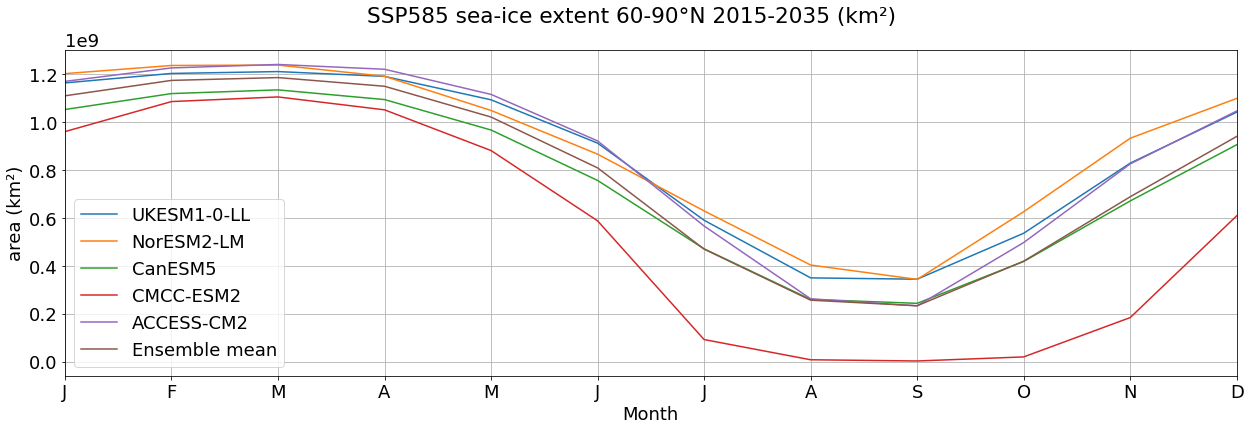

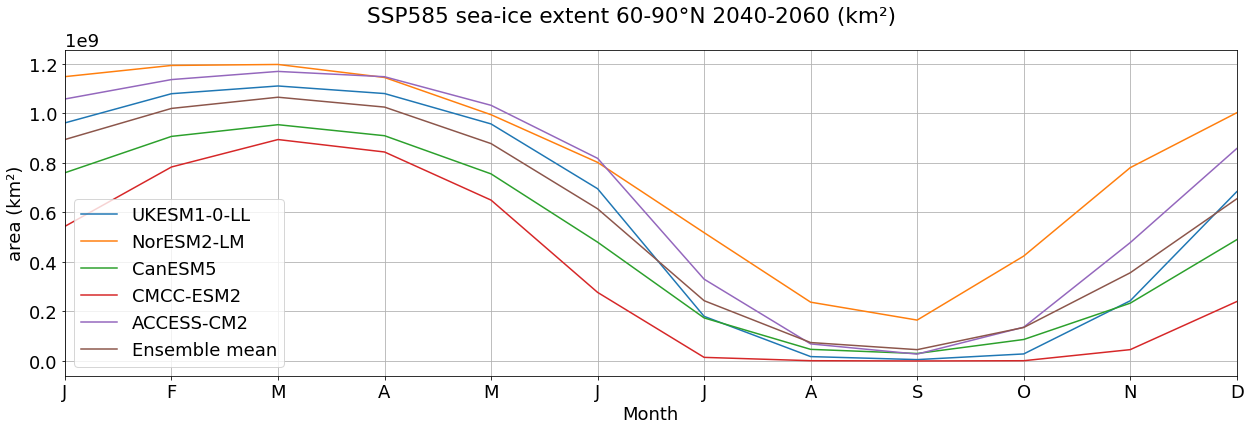

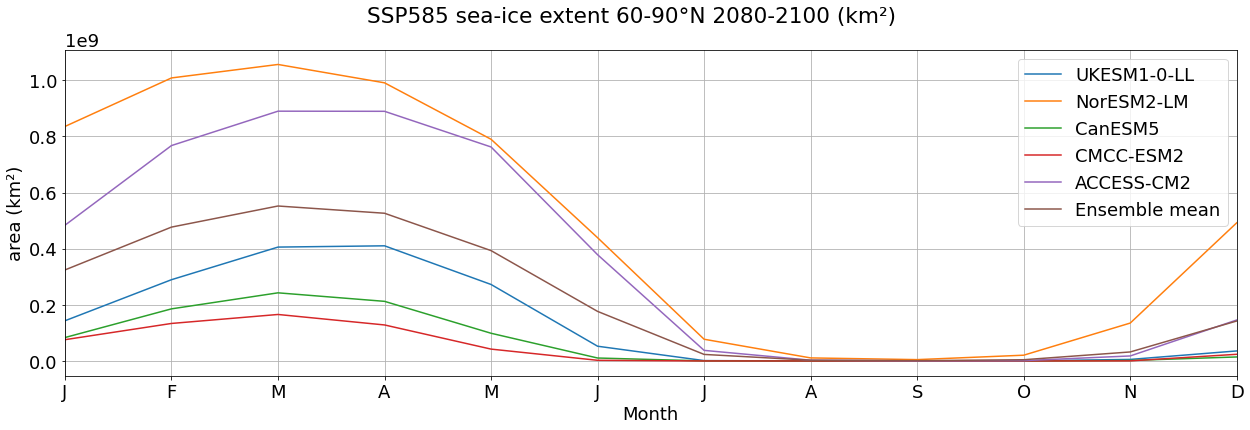

In [5]:
for s in ensemble_time_slices:
    ensemble_processed = [{ 
        'data': libs.analysis.monthly_weighted(
            item['data'] / 1000000, 
            weight,
            method='sum'
        ),
        'label': item['label']
    } for item in s['ensemble']]
    
    # Calculate and add ensemble mean
    ensemble_processed.append(libs.analysis.ensemble_mean(ensemble_processed))
    
    s_label = s['label']

    libs.plot.monthly_variability(
        ensemble_processed,
        title=f'SSP585 sea-ice extent 60-90°N {s_label} ({area_units})',
        ylabel=f'area ({area_units})'
    )

### Regional sea-ice area (time)

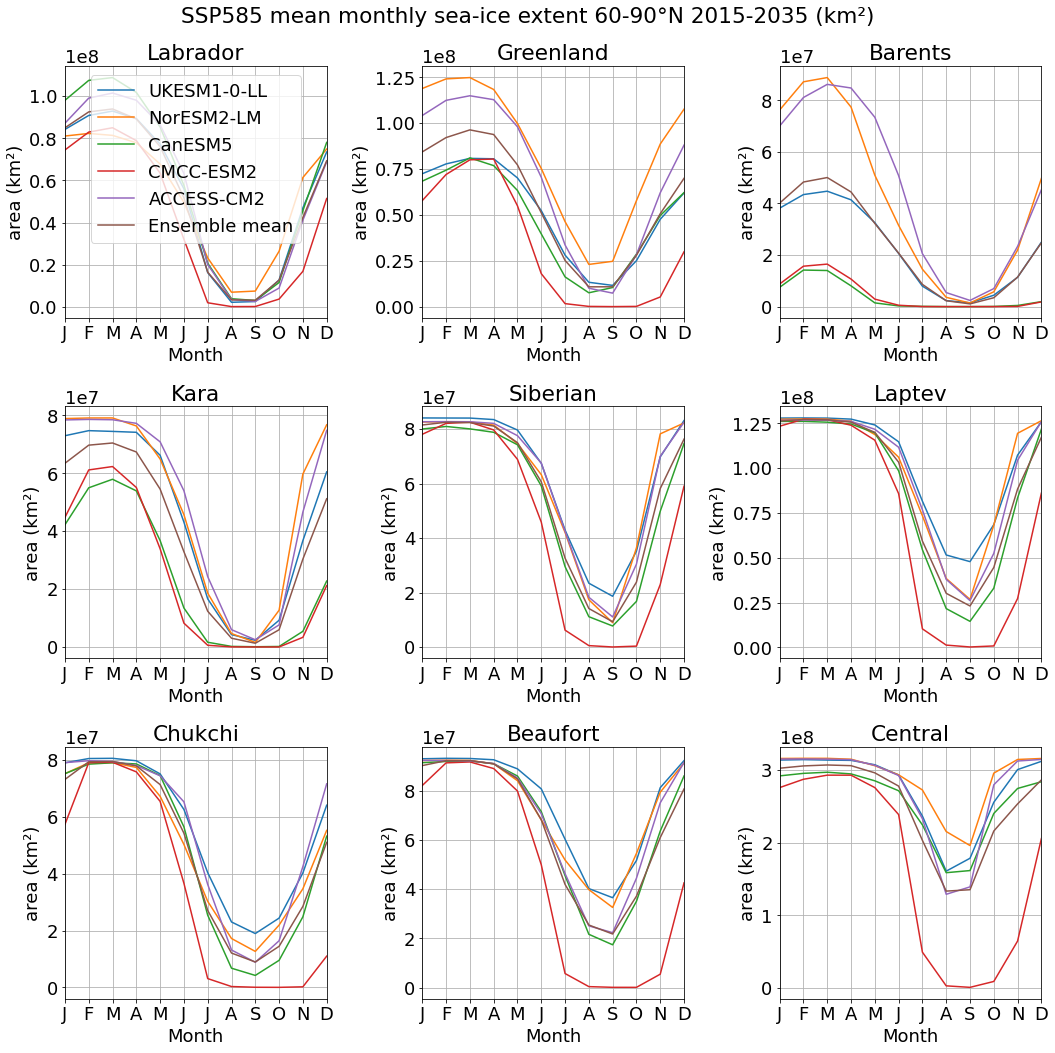

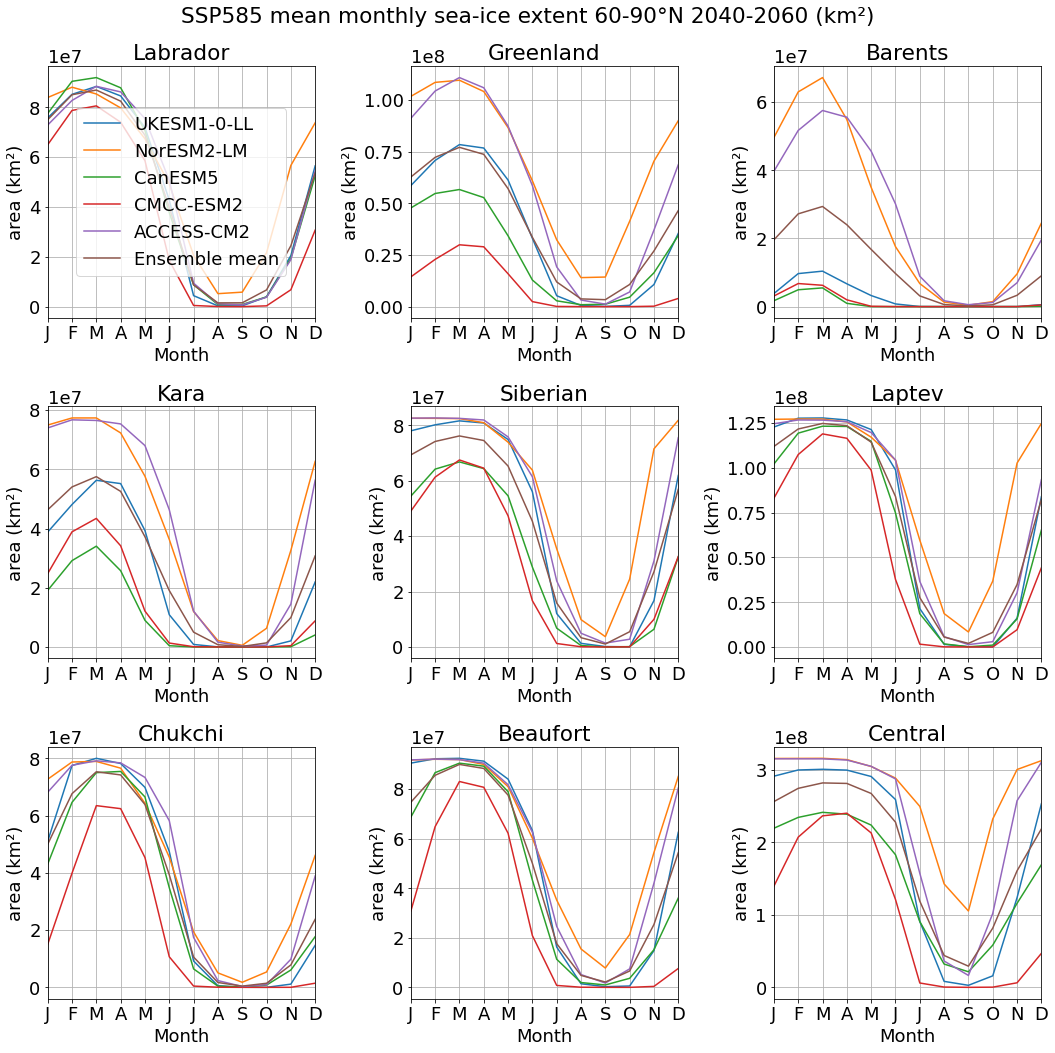

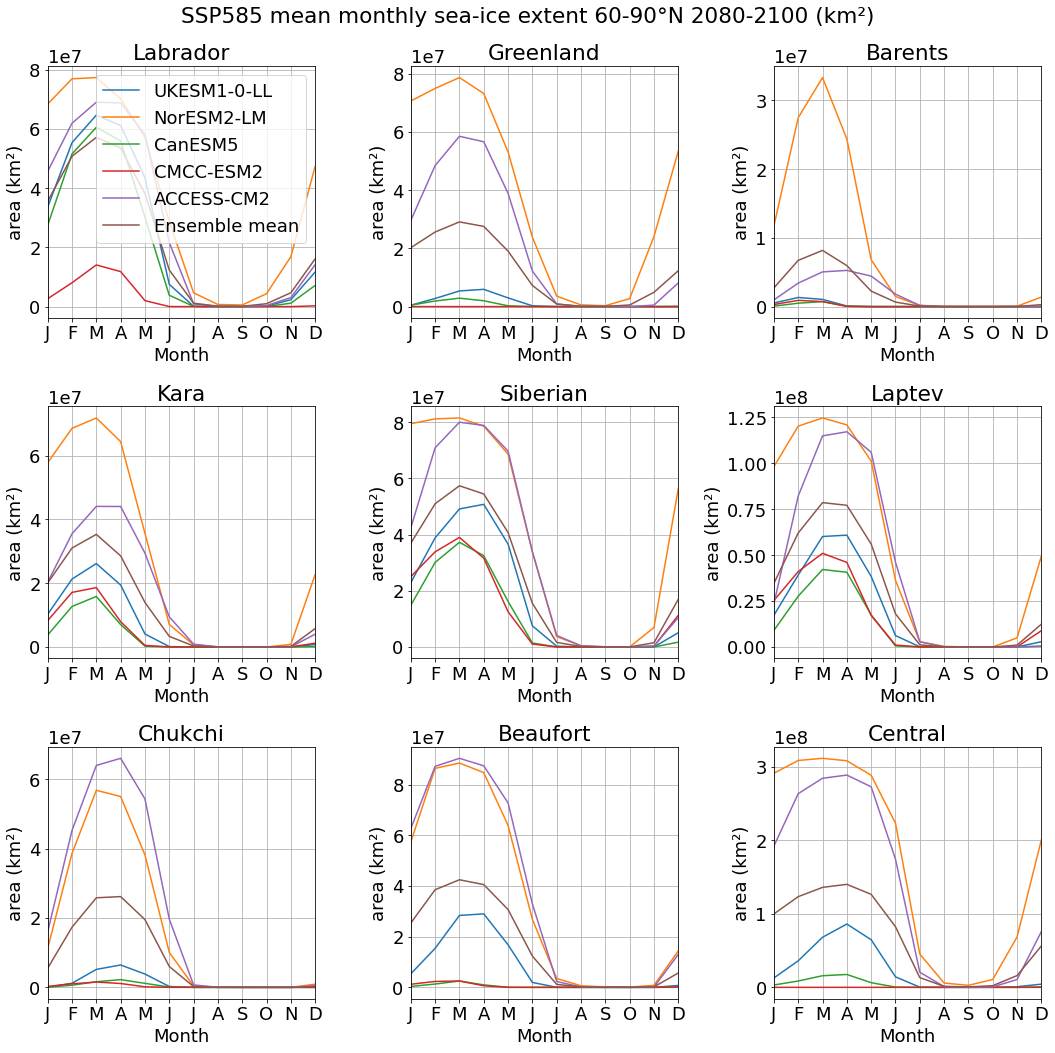

In [6]:
for s in ensemble_time_slices:
    s_label = s['label']

    libs.plot.monthly_variability_regional(
        s['ensemble'], 
        title=f'SSP585 mean monthly sea-ice extent 60-90°N {s_label} ({area_units})',
        ylabel=f'area ({area_units})',
        mask_type='ocean',
        calc_ensemble_mean=True,
        process=lambda x: libs.analysis.monthly_weighted(
            x / 1000000, 
            weight,
            method='sum'
        )
    )